<a href="https://colab.research.google.com/github/Henry-P-Ding/grain-growth-simulation/blob/main/qstates_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation
``numpy`` is used for numerical operations. 

``matplotlib`` is used to graph results. 

``scipy`` and ``shapeply`` are used to generate initial voronoi grain lattices.

In [93]:
import numpy as np
import matplotlib.pyplot as plt

Constants for the q-states model. ``n_grains`` determines the number of initial crystal grains. ``SIZE`` refers to the lattice width/height, which is a square in lattice vector space, but may be differently shaped in physical space depending on the lattice type.

In [94]:
# Constants for the Q-States Model
N_GRAINS = 10
SIZE = 40

The grain lattice is populated by selecting ``n_grains`` random sites as grain origins, and then generating a voronoi diagram based on Euclidean distance to grain origins.

In [95]:
def generate_lattice(size, n_grains, basis):
  """
  Generates voronoi lattice with crystal grains.
  """
  lattice = np.ones(shape=(SIZE, SIZE)) * -1

  # determins unique grain origins
  origins = np.ones(shape=(n_grains, 2)) * -1
  o_count = 0
  while o_count < n_grains:
    p = [np.random.randint(0, SIZE), np.random.randint(0, SIZE)]
    if not p in origins[:o_count].tolist():
      origins[o_count] = np.array(p)
      lattice[p[0], p[1]] = o_count
      o_count += 1

  # fill latest with nearest origin by Euclidean distance
  for i in range(SIZE):
    for j in range(SIZE):
      if lattice[i, j] == -1:
        rel = np.tile(np.array([i, j]), (n_grains, 1)) - origins
        # change of basis
        cart_rel = np.matmul(basis, rel.T).T
        sq_dist = np.sum(cart_rel ** 2, axis=1)
        # choose a random minimum distance index
        lattice[i, j] = np.random.choice(np.where(sq_dist == sq_dist.min())[0])

  return lattice


grain_lattice = generate_lattice(SIZE, N_GRAINS, np.array([[1, 0], [0, 1]]))
grain_lattice

array([[7., 7., 7., ..., 0., 0., 0.],
       [7., 7., 7., ..., 0., 0., 0.],
       [7., 7., 7., ..., 0., 0., 0.],
       ...,
       [5., 5., 5., ..., 6., 6., 6.],
       [5., 5., 5., ..., 6., 6., 6.],
       [5., 5., 5., ..., 6., 6., 6.]])

In [96]:
def find_boundaries(lattice, nn_f):
  """
  Finds boundary lattice positions, with neighbors having different lattice values.

  Arguments:
  lattice -- lattice to return boundaries
  nn_f -- function to find nearest neighbor indices given position, returns
  ndarray with row neighbor positions
  """
  size = lattice.shape[0]
  boundaries = []
  for i in range(size):
    for j in range(size):
      grain = lattice[i, j]
      # finds unique nearest neighbor lattice sites within lattice boundaries
      nn = np.unique(np.clip(nn_f(np.array([i, j])), 0, size - 1), axis=0)
      for n in nn:
        # determines if any neighbors have a different lattice value.
        # if true, then the site is on a boundary
        if lattice[n[0], n[1]] != grain:
          boundaries.append(np.array([i, j]))
          break

  return np.array(boundaries)
  

grain_boundaries = find_boundaries(grain_lattice, lambda p:np.array([p+[0, -1], 
                                                                     p+[-1, 0],
                                                                     p+[0, 1], 
                                                                     p+[1, 0]]))

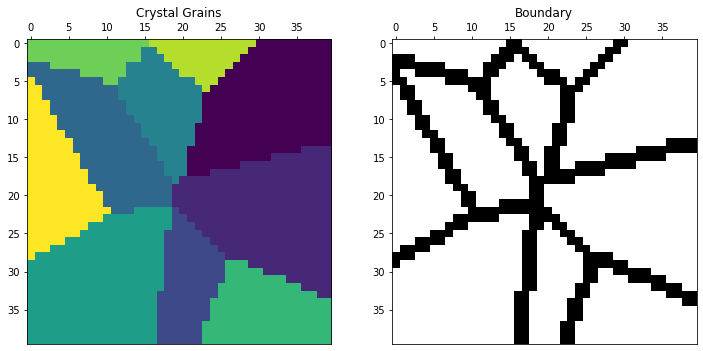

In [99]:
# Visualization of grain lattice and boundaries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

boundary_marked = np.zeros(shape=(SIZE, SIZE))
for b in grain_boundaries:
  boundary_marked[b[0], b[1]] = 10

fig, axs = plt.subplots(1, 2)
fig.set_size_inches((12, 12))
axs[0].imshow(grain_lattice, interpolation='nearest')
axs[0].xaxis.tick_top()
axs[0].set_title("Crystal Grains")
axs[1].imshow(boundary_marked, cmap=cm.binary, interpolation='nearest')
axs[1].xaxis.tick_top()
axs[1].set_title("Boundary")

fig.show()